<a href="/assets/lecture07_code.ipynb" class="link-button">Download</a>
<a href="https://colab.research.google.com/github/technion046195/technion046195/blob/master/content/lecture07/code.ipynb" target="_blank">
<img src="../assets/colab-badge.svg" style="display:inline"/>
</a>

<center><h1>
הרצאה 7 - הגישה הדיסקרימינטיבית היסתברותית
</h1></center>

## Setup

In [ ]:
## Importing packages
import os # A build in package for interacting with the OS. For example to create a folder.
import numpy as np  # Numerical package (mainly multi-dimensional arrays and linear algebra)
import pandas as pd  # A package for working with data frames
import matplotlib.pyplot as plt  # A plotting package
import imageio  # A package to read and write image (is used here to save gif images)
import tabulate  # A package from pretty printing tables
from graphviz import Digraph  # A package for plothing graphs (of nodes and edges)

## Setup matplotlib to output figures into the notebook
## - To make the figures interactive (zoomable, tooltip, etc.) use ""%matplotlib notebook" instead
%matplotlib inline

## Setting some nice matplotlib defaults
plt.rcParams['figure.figsize'] = (4.5, 4.5)  # Set default plot's sizes
plt.rcParams['figure.dpi'] = 120  # Set default plot's dpi (increase fonts' size)
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

## Auxiliary function for prining equations, pandas tables and images in cells output
from IPython.core.display import display, HTML, Latex, Markdown

## Create output folder
if not os.path.isdir('./output'):
    os.mkdir('./output')

## Sigmoid

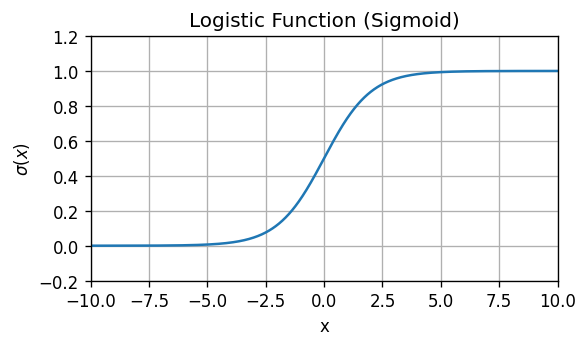

In [ ]:
x_grid = np.arange(-10, 10 + 1e-9 ,0.01)

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x_grid, 1 / (1 + np.exp(-x_grid)))
ax.set_title('Logistic Function (Sigmoid)')
ax.set_xlabel('x')
ax.set_ylabel(r'$\sigma(x)$')
ax.set_xlim(x_grid.min(), x_grid.max())
ax.set_ylim(-0.2, 1.2)
plt.tight_layout()
fig.savefig('./output/sigmoid.png', dpi=240)

## Credit Card Fraud Detection

In [ ]:
mean_legit = np.array([54, 54])
std_legit = 18
mean_fraud1 = np.array([27, 27])
std_fraud1 = 7.2
mean_fraud2 = np.array([81, 81])
std_fraud2 = 7.2

n_legit = 200
n_fraud1 = 25
n_fraud2 = 25

rand_gen = np.random.RandomState(1)

x = np.concatenate((
        rand_gen.randn(n_legit, 2) * std_legit + mean_legit,
        rand_gen.randn(n_fraud1, 2) * std_fraud1 + mean_fraud1,
        rand_gen.randn(n_fraud2, 2) * std_fraud2 + mean_fraud2,
    ), axis=0)

y = np.concatenate((np.zeros(n_legit, dtype=bool), np.ones(n_fraud1 + n_fraud2, dtype=bool)))

x_grid = np.stack(np.meshgrid(np.linspace(0, 100, 300), np.linspace(0, 100, 300)), axis=2)

In [ ]:
from matplotlib.colors import ListedColormap
def plot_grid_predict(ax, h, x_grid):
    cmap = ListedColormap(plt.cm.tab10([0, 1]))
    grid_predict = h(x_grid.reshape(-1, 2)).reshape(x_grid.shape[:2])
    img_obj = ax.imshow(grid_predict, extent=[0, 100, 0, 100],
              origin='lower',
              cmap=cmap,
              alpha=0.2,
              interpolation='nearest',
              zorder=-1,
              )
    return img_obj

In [ ]:
from scipy.stats import multivariate_normal
def plot_gaussian(ax, x_grid, mu, cov_mat, colors='k'):
    norm_dist = multivariate_normal(mu, cov_mat)
    ax.contour(x_grid[:, :, 0], x_grid[:, :, 1],
               norm_dist.pdf(np.stack((x_grid[:, :, 0], x_grid[:, :, 1]), axis=2)),
               colors=colors,
               alpha=0.5,
#                levels=np.array([0.25, 0.5, 0.75, 1]) * np.exp(-3 ** 2 / 2) / 2 / np.pi / np.linalg.det(cov_mat) ** 0.5,
               levels=np.exp(-np.array([2, 1.5, 1, 0.5]) ** 2 / 2) / 2 / np.pi / np.linalg.det(cov_mat) ** 0.5,
               )

In [ ]:
def calc_score(h_func, x, y):
    y_hat = h_func(x)
    score = (y != y_hat).mean()
    return score

### Train-Validation-Test split

In [ ]:
n_samples = x.shape[0]

## Generate a random generator with a fixed seed
rand_gen = np.random.RandomState(0)

## Generating a vector of indices
indices = np.arange(n_samples)

## Shuffle the indices
rand_gen.shuffle(indices)

## Split the indices into 60% train / 20% validation / 20% test
n_samples_train = int(n_samples * 0.6)
n_samples_val = int(n_samples * 0.2)
train_indices = indices[:n_samples_train]
val_indices = indices[n_samples_train:(n_samples_train + n_samples_val)]
test_indices = indices[(n_samples_train + n_samples_val):]

train_full_indices = np.concatenate((train_indices, val_indices))

x_train_full = x[train_full_indices]
y_train_full = y[train_full_indices]
x_train = x[train_indices]
y_train = y[train_indices]
x_val = x[val_indices]
y_val = y[val_indices]
x_test = x[test_indices]
y_test = y[test_indices]

### The dataset

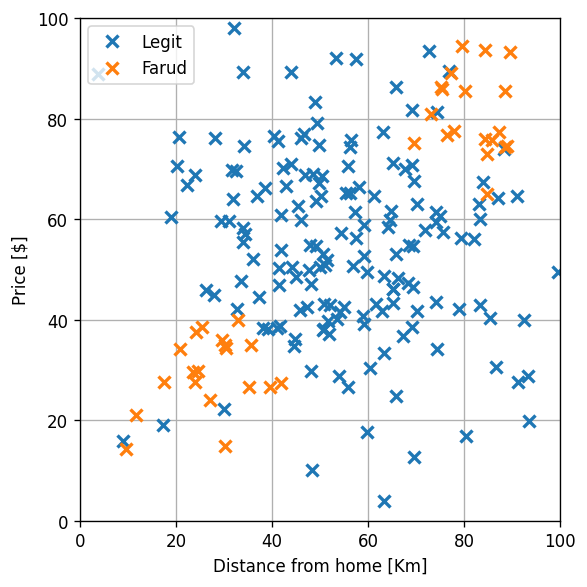

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x_train_full[~y_train_full, 0], x_train_full[~y_train_full, 1], 'x', label='Legit', ms=7, mew=2)
ax.plot(x_train_full[y_train_full, 0], x_train_full[y_train_full, 1], 'x', label='Farud', ms=7, mew=2)
ax.set_xlabel('Distance from home [Km]')
ax.set_ylabel('Price [$]')
ax.set_xlim(x_grid[0, 0, 0].min(), x_grid[0, -1, 0].max())
ax.set_ylim(x_grid[0, 0, 1].min(), x_grid[-1, 0, 1].max())
plt.tight_layout()
ax.legend(loc='upper left')
fig.savefig('./output/transactions_dataset.png', dpi=240)

### QDA

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

## Create the classifier object
clf = QuadraticDiscriminantAnalysis(store_covariance=True)

## Train the classifier
clf.fit(x_train_full, y_train_full)

h_func = lambda x: clf.predict(x)

print(clf.priors_[0])
print(clf.priors_[1])
print(clf.means_[0])
print(clf.means_[1])
print(clf.covariance_[0])
print(clf.covariance_[1])

0.81
0.19
[55.14663966 54.59891299]
[54.35763261 55.2396479 ]
[[350.92189736 -42.89075385]
 [-42.89075385 336.05363944]]
[[817.94996627 730.50751129]
 [730.50751129 741.66259061]]


The misclassification rate on the test is: 0.08


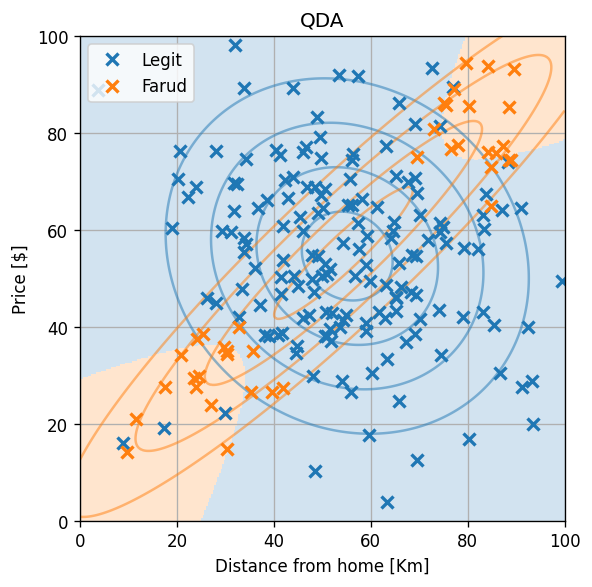

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x_train_full[~y_train_full, 0], x_train_full[~y_train_full, 1], 'x', label='Legit', ms=7, mew=2)
ax.plot(x_train_full[y_train_full, 0], x_train_full[y_train_full, 1], 'x', label='Farud', ms=7, mew=2)
plot_grid_predict(ax, h_func, x_grid)
plot_gaussian(ax, x_grid, clf.means_[0], clf.covariance_[0], colors=plt.cm.tab10([0]))
plot_gaussian(ax, x_grid, clf.means_[1], clf.covariance_[1], colors=plt.cm.tab10([1]))
ax.set_title('QDA')
ax.set_xlabel('Distance from home [Km]')
ax.set_ylabel('Price [$]')
ax.set_xlim(x_grid[0, 0, 0].min(), x_grid[0, -1, 0].max())
ax.set_ylim(x_grid[0, 0, 1].min(), x_grid[-1, 0, 1].max())
plt.tight_layout()
ax.legend(loc='upper left')
fig.savefig('./output/transactions_qda.png', dpi=240)

print(f'The misclassification rate on the test is: {calc_score(h_func, x_test, y_test):.2f}')

## Credit Card Fraud Detection - Single Gaussian

In [ ]:
rand_gen = np.random.RandomState(1)

x = np.concatenate((
        rand_gen.randn(n_legit, 2) * std_legit + mean_legit,
        rand_gen.randn(n_fraud1, 2) * std_fraud1 + mean_fraud1,
    ), axis=0)

y = np.concatenate((np.zeros(n_legit, dtype=bool), np.ones(n_fraud1, dtype=bool)))

### Train-Validation-Test split

In [ ]:
n_samples = x.shape[0]

## Generate a random generator with a fixed seed
rand_gen = np.random.RandomState(1)

## Generating a vector of indices
indices = np.arange(n_samples)

## Shuffle the indices
rand_gen.shuffle(indices)

## Split the indices into 60% train / 20% validation / 20% test
n_samples_train = int(n_samples * 0.6)
n_samples_val = int(n_samples * 0.2)
train_indices = indices[:n_samples_train]
val_indices = indices[n_samples_train:(n_samples_train + n_samples_val)]
test_indices = indices[(n_samples_train + n_samples_val):]

train_full_indices = np.concatenate((train_indices, val_indices))

x_train_full = x[train_full_indices]
y_train_full = y[train_full_indices]
x_train = x[train_indices]
y_train = y[train_indices]
x_val = x[val_indices]
y_val = y[val_indices]
x_test = x[test_indices]
y_test = y[test_indices]

### The dataset

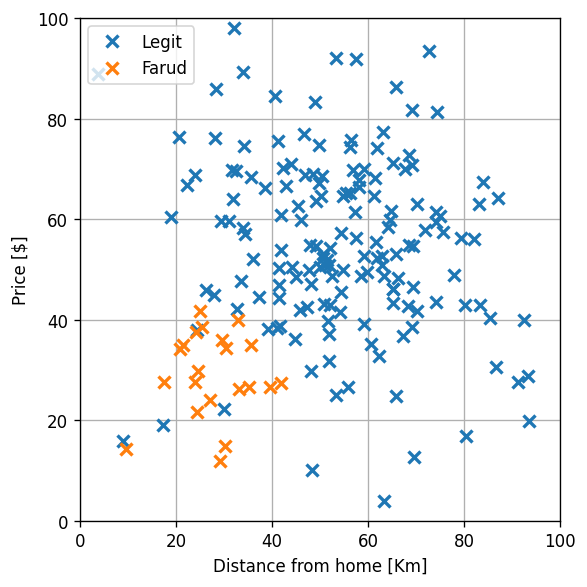

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x_train_full[~y_train_full, 0], x_train_full[~y_train_full, 1], 'x', label='Legit', ms=7, mew=2)
ax.plot(x_train_full[y_train_full, 0], x_train_full[y_train_full, 1], 'x', label='Farud', ms=7, mew=2)
ax.set_xlabel('Distance from home [Km]')
ax.set_ylabel('Price [$]')
ax.set_xlim(x_grid[0, 0, 0].min(), x_grid[0, -1, 0].max())
ax.set_ylim(x_grid[0, 0, 1].min(), x_grid[-1, 0, 1].max())
plt.tight_layout()
ax.legend(loc='upper left')
fig.savefig('./output/transactions_single_dataset.png', dpi=240)

### QDA

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

## Create the classifier object
clf = QuadraticDiscriminantAnalysis(store_covariance=True)

## Train the classifier
clf.fit(x_train_full, y_train_full)

h_func = lambda x: clf.predict(x)

print(clf.priors_[0])
print(clf.priors_[1])
print(clf.means_[0])
print(clf.means_[1])
print(clf.covariance_[0])
print(clf.covariance_[1])

0.8833333333333333
0.11666666666666667
[54.14155305 54.82132181]
[27.70590903 29.081539  ]
[[302.65694311 -50.36767655]
 [-50.36767655 314.59325611]]
[[55.67322197  6.88234019]
 [ 6.88234019 72.0484076 ]]


The misclassification rate on the test is: 0.00


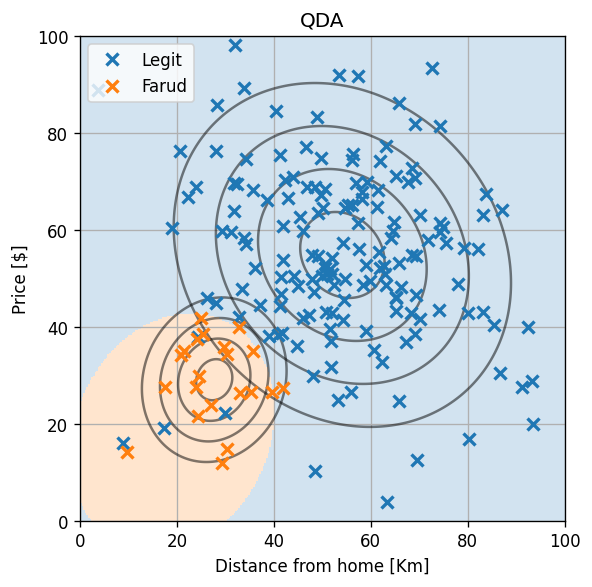

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x_train_full[~y_train_full, 0], x_train_full[~y_train_full, 1], 'x', label='Legit', ms=7, mew=2)
ax.plot(x_train_full[y_train_full, 0], x_train_full[y_train_full, 1], 'x', label='Farud', ms=7, mew=2)
plot_grid_predict(ax, h_func, x_grid)
plot_gaussian(ax, x_grid, clf.means_[0], clf.covariance_[0])
plot_gaussian(ax, x_grid, clf.means_[1], clf.covariance_[1])
ax.set_title('QDA')
ax.set_xlabel('Distance from home [Km]')
ax.set_ylabel('Price [$]')
ax.set_xlim(x_grid[0, 0, 0].min(), x_grid[0, -1, 0].max())
ax.set_ylim(x_grid[0, 0, 1].min(), x_grid[-1, 0, 1].max())
plt.tight_layout()
ax.legend(loc='upper left')
fig.savefig('./output/transactions_single_qda.png', dpi=240)

print(f'The misclassification rate on the test is: {calc_score(h_func, x_test, y_test):.2f}')

### LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Create the classifier object
clf = LinearDiscriminantAnalysis(store_covariance=True)

## Train the classifier
clf.fit(x_train_full, y_train_full)

h_func = lambda x: clf.predict(x)

print(clf.priors_[0])
print(clf.priors_[1])
print(clf.means_[0])
print(clf.means_[1])
print(clf.covariance_)

0.8833333333333333
0.11666666666666667
[54.14155305 54.82132181]
[27.70590903 29.081539  ]
[[271.8514525  -43.44692273]
 [-43.44692273 284.14834787]]


The misclassification rate on the test is: 0.02


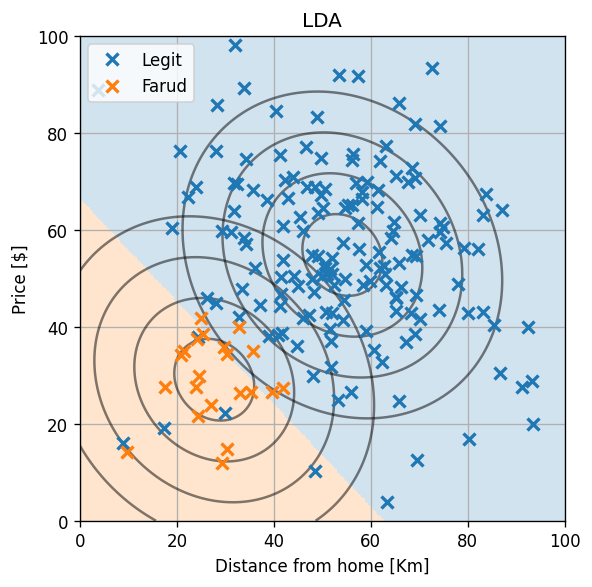

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x_train_full[~y_train_full, 0], x_train_full[~y_train_full, 1], 'x', label='Legit', ms=7, mew=2)
ax.plot(x_train_full[y_train_full, 0], x_train_full[y_train_full, 1], 'x', label='Farud', ms=7, mew=2)
plot_grid_predict(ax, h_func, x_grid)
plot_gaussian(ax, x_grid, clf.means_[0], clf.covariance_)
plot_gaussian(ax, x_grid, clf.means_[1], clf.covariance_)
ax.set_title('LDA')
ax.set_xlabel('Distance from home [Km]')
ax.set_ylabel('Price [$]')
ax.set_xlim(x_grid[0, 0, 0].min(), x_grid[0, -1, 0].max())
ax.set_ylim(x_grid[0, 0, 1].min(), x_grid[-1, 0, 1].max())
plt.tight_layout()
ax.legend(loc='upper left')
fig.savefig('./output/transactions_single_lda.png', dpi=240)

print(f'The misclassification rate on the test is: {calc_score(h_func, x_test, y_test):.2f}')

## Linear Logistic Regression

In [ ]:
## The objective function
## ======================
def aug(x):
    x = (x - 50) / 20
    x = np.concatenate((x, np.ones((x.shape[0], 1))), axis=1)
    return x
    
def model(x, y, theta):
    prob = 1 / (1 + np.exp((-1) ** y * (x @ theta)))
    return prob

def objective(x, y, theta):
    return -np.log(model(x, y, theta)).mean()

def objective_grad(x, y, theta):
    return (((1 - model(x, y, theta)) * (-1) ** y)[:, None] * x).mean(axis=0)

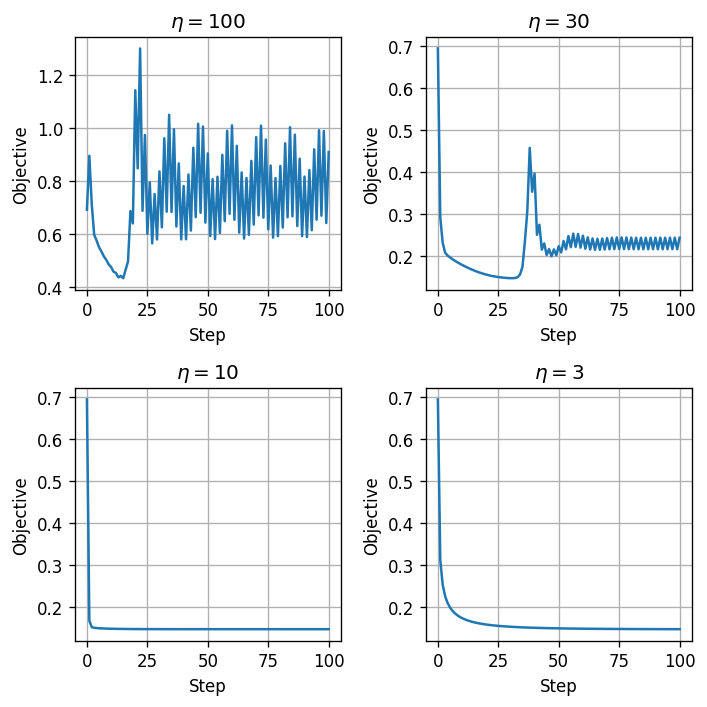

In [ ]:
import tqdm.notebook as tqdm

## The gradient decent algorithm
## =============================
def basic_gradient_decent(objective_grad, eta, n_iters, x, y):
    ## Initialize theta
    theta = np.zeros(aug(x).shape[1])

    ## Initialize lists to store intermidiate results for plotting
    theta_list = [theta.copy()]

    ## Perforing the update steps
    for i_iter in tqdm.tqdm(range(1, n_iters + 1)):
        theta -= eta * objective_grad(aug(x), y, theta)
        
        ## Store intermidiate results
        theta_list.append(theta.copy())
    
    theta_list = np.array(theta_list)
    return theta_list

n_iters = 100
etas_list = (1e2, 3e1, 1e1, 3e0)

iters_list = np.arange(0, n_iters + 1)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i_eta, eta in enumerate(etas_list):
    theta_list = basic_gradient_decent(objective_grad, eta, n_iters, x_train_full, y_train_full)
    
    objective_list = []
    for i_iter in iters_list:
        objective_list.append(objective(aug(x_train_full), y_train_full, theta_list[i_iter]))
    objective_list = np.array(objective_list)

    ## Plot
    ax = axes.flat[i_eta]
    ax.plot(iters_list, objective_list)
    ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
    ax.set_xlabel('Step')
    ax.set_ylabel('Objective')
fig.tight_layout()
fig.savefig('./output/transactions_single_selecting_eta.png', dpi=240)

array([-2.65417808, -2.13262482, -4.37171625])

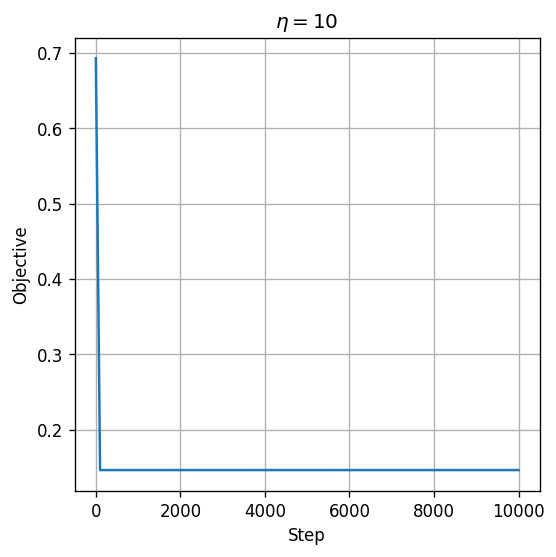

In [ ]:
eta = 1e1
n_iters = 10000

theta_list = basic_gradient_decent(objective_grad, eta, n_iters, x_train_full, y_train_full)

iters_list = np.arange(0, n_iters + 1, 100)
objective_list = []
for i_iter in iters_list:
    objective_list.append(objective(aug(x_train_full), y_train_full, theta_list[i_iter]))
objective_list = np.array(objective_list)

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(iters_list, objective_list)
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective')

theta = theta_list[-1]

h_func = lambda x: model(aug(x), np.ones(x.shape[0], dtype=bool), theta) > 0.5

theta

The misclassification rate on the test is: 0.02


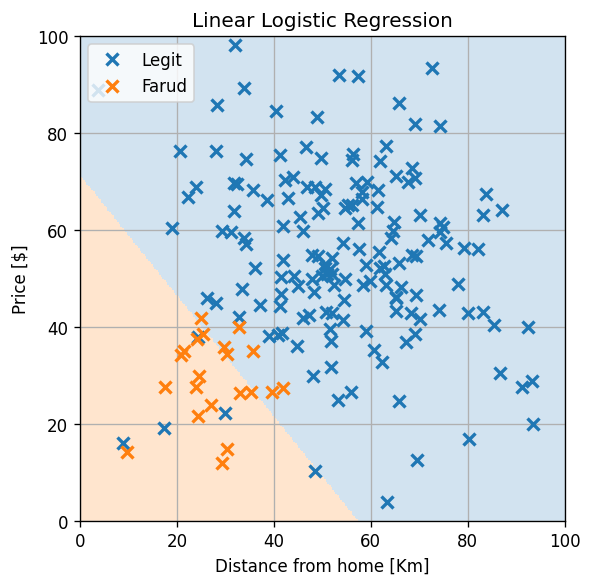

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x_train_full[~y_train_full, 0], x_train_full[~y_train_full, 1], 'x', label='Legit', ms=7, mew=2)
ax.plot(x_train_full[y_train_full, 0], x_train_full[y_train_full, 1], 'x', label='Farud', ms=7, mew=2)
plot_grid_predict(ax, h_func, x_grid)
ax.set_title('Linear Logistic Regression')
ax.set_xlabel('Distance from home [Km]')
ax.set_ylabel('Price [$]')
ax.set_xlim(x_grid[0, 0, 0].min(), x_grid[0, -1, 0].max())
ax.set_ylim(x_grid[0, 0, 1].min(), x_grid[-1, 0, 1].max())
plt.tight_layout()
ax.legend(loc='upper left')
fig.savefig('./output/transactions_single_linear_logistic.png', dpi=240)

print(f'The misclassification rate on the test is: {calc_score(h_func, x_test, y_test):.2f}')

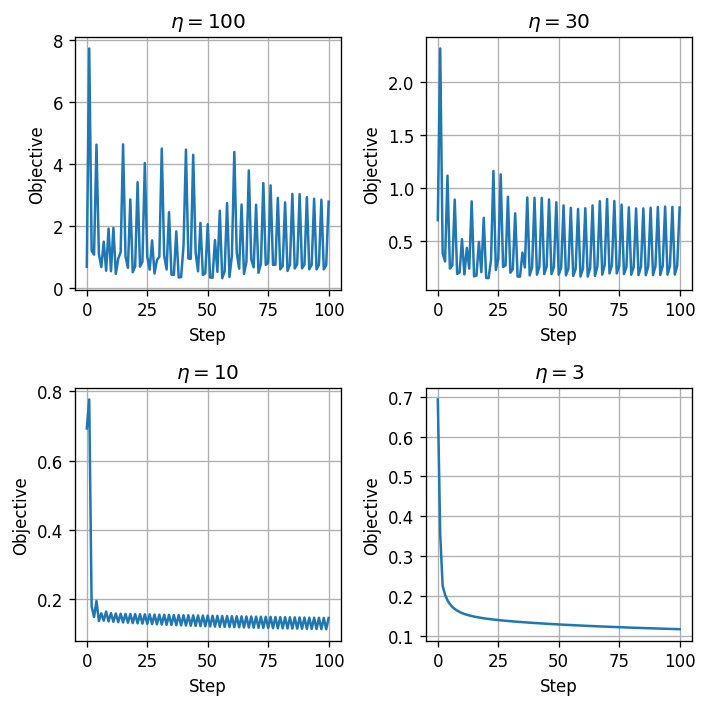

In [ ]:
def aug(x):
    x = (x - 50) / 20
    x = np.stack((
        np.ones(x.shape[0]),
        x[:, 0],
        x[:, 1],
        x[:, 0] ** 2,
        x[:, 0] * x[:, 1],
        x[:, 1] ** 2,
        ), axis=1)
    return x

n_iters = 100
etas_list = (1e2, 3e1, 1e1, 3e0)

iters_list = np.arange(0, n_iters + 1)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i_eta, eta in enumerate(etas_list):
    theta_list = basic_gradient_decent(objective_grad, eta, n_iters, x_train_full, y_train_full)
    
    objective_list = []
    for i_iter in iters_list:
        objective_list.append(objective(aug(x_train_full), y_train_full, theta_list[i_iter]))
    objective_list = np.array(objective_list)

    ## Plot
    ax = axes.flat[i_eta]
    ax.plot(iters_list, objective_list)
    ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
    ax.set_xlabel('Step')
    ax.set_ylabel('Objective')
fig.tight_layout()

array([-11.89011334, -11.04081228, -13.32078064,  -3.57694258,
        -1.72770304,  -4.52566342])

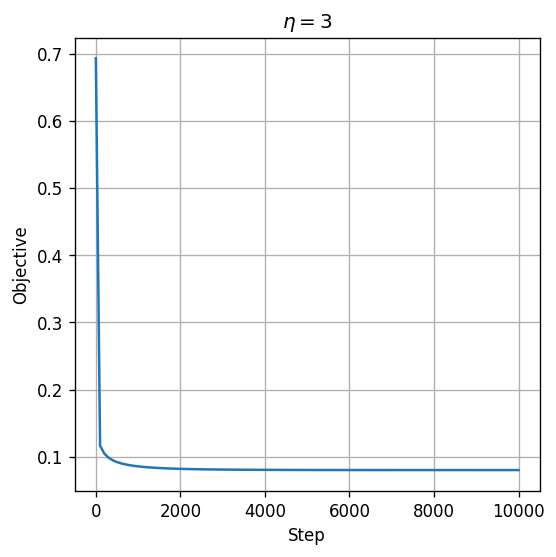

In [ ]:
eta = 3e0
n_iters = 10000

theta_list = basic_gradient_decent(objective_grad, eta, n_iters, x_train_full, y_train_full)

iters_list = np.arange(0, n_iters + 1, 100)
objective_list = []
for i_iter in iters_list:
    objective_list.append(objective(aug(x_train_full), y_train_full, theta_list[i_iter]))
objective_list = np.array(objective_list)

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(iters_list, objective_list)
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective')

theta = theta_list[-1]

h_func = lambda x: model(aug(x), np.ones(x.shape[0], dtype=bool), theta) > 0.5

theta

The misclassification rate on the test is: 0.00


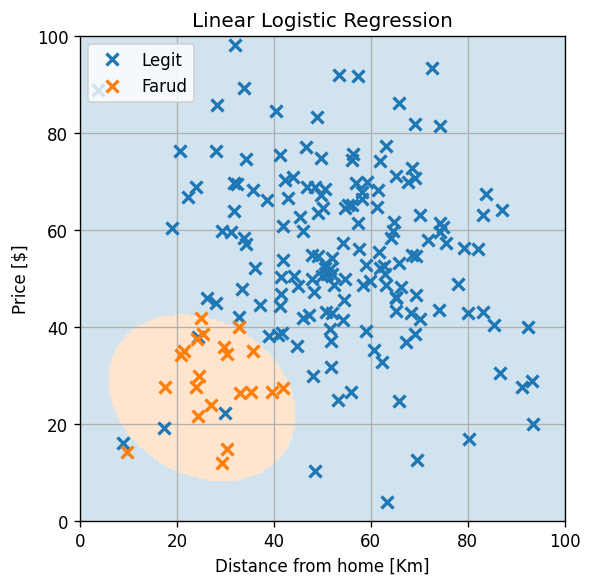

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x_train_full[~y_train_full, 0], x_train_full[~y_train_full, 1], 'x', label='Legit', ms=7, mew=2)
ax.plot(x_train_full[y_train_full, 0], x_train_full[y_train_full, 1], 'x', label='Farud', ms=7, mew=2)
plot_grid_predict(ax, h_func, x_grid)
ax.set_title('Linear Logistic Regression')
ax.set_xlabel('Distance from home [Km]')
ax.set_ylabel('Price [$]')
ax.set_xlim(x_grid[0, 0, 0].min(), x_grid[0, -1, 0].max())
ax.set_ylim(x_grid[0, 0, 1].min(), x_grid[-1, 0, 1].max())
plt.tight_layout()
ax.legend(loc='upper left')
fig.savefig('./output/transactions_single_quadric_logistic.png', dpi=240)

print(f'The misclassification rate on the test is: {calc_score(h_func, x_test, y_test):.2f}')